In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

# Attention Mechanisms

In the realm of neural networks and specifically in transformer models, attention mechanisms play a pivotal role in enhancing the model's ability to process and understand sequences of data. There are three primary types of attention mechanisms:

1. **Encoder-Decoder Attention:** This form of attention allows the decoder to focus on different parts of the input sequence during the decoding process. An implementation of this mechanism can be found in [this repository](https://github.com/abtraore/nmt-rnn-pytorch-from-scratch), which focuses on neural machine translation using PyTorch from scratch.
2. **Causal (or Autoregressive) Attention:** This mechanism is designed to ensure that the model only attends to previously seen elements in the sequence, making it suitable for generating sequences where the prediction of each element depends only on the preceding elements.
3. **Bi-directional Self-Attention:** Unlike causal attention, bi-directional self-attention allows the model to look at both past and future elements in the sequence. This is particularly useful in tasks where understanding the entire context is crucial.

Having already implemented encoder-decoder attention, the focus will now shift to exploring and implementing the latter two mechanisms: causal attention and bi-directional self-attention.

At the core of any attention mechanism utilized within transformers is the **Dot Product Attention**. This fundamental operation computes the similarity between query and key vectors, which influences how much focus, or "attention," is given to corresponding values in the sequence. Understanding and implementing dot product attention is essential for developing efficient and effective transformer models.

### 1.1 - Dot Product Attention

Dot product attention is calculated with the formula: 

$$\textrm{softmax} \left(\frac{Q K^T}{\sqrt{d}} + M \right) V$$

- **$Q, K, V$** are the query, key, and value matrices respectively.
- **$K^T$** is the transpose of $K$.
- **$\sqrt{d}$** is the square root of the embedding dimension, used as a scaling factor to normalize the dot product, preventing large values that could destabilize training.
- **$M$** is an optional mask that can be added to ignore specific positions, typically used in sequential tasks to prevent looking ahead.
- The output is weighted by the softmax of the scaled dot product between queries and keys, adjusted for the optional mask, and then applied to the values $V$. This mechanism allows the model to focus on the most relevant parts of the input data.

In [2]:
# Dummy q,k,v matrix. They all should have the same shape.
q = torch.tensor([[1,0,0],[0,1,0]],dtype=torch.float)
k = torch.tensor([[1,2,3],[4,5,6]],dtype=torch.float)
v = torch.tensor([[0,1,0],[1,0,1]],dtype=torch.float)

# The mask used if we want to compute the causal dot product attention.
m = torch.tensor([[1,0],[1,0]],dtype=torch.float)

In [3]:
def dot_product_attention(q,k,v,mask=None,scale=True):

    matmul_qk = q @ k.T

    if scale:
        dk = torch.tensor(k.shape[-1],dtype=torch.float)
        matmul_qk /= torch.sqrt(dk)

    if mask is not None:
        matmul_qk = matmul_qk + (1-mask) * -1e9

    attention_weights = F.softmax(matmul_qk,dim=-1)

    print(f"Attention weights:\n{attention_weights}")

    attention_output = attention_weights @ v

    return attention_output

dot_product_attention(q,k,v,mask=m)

Attention weights:
tensor([[1., 0.],
        [1., 0.]])


tensor([[0., 1., 0.],
        [0., 1., 0.]])

### 1.2 - Causal dot product attention



In [4]:
def causal_dot_product_attention(q,k,v,scale=True):
    
    # The size of the mask equal the penultimate dimention of the query. (seq length)
    mask_size = q.shape[-2]

    # Creates a matrix with ones below the diagonal and 0s above.
    mask = torch.tril(torch.ones(mask_size,mask_size))
    
    print(f"Causal mask:\n{mask}\n")

    return dot_product_attention(q,k,v,mask=mask,scale=scale)

causal_dot_product_attention(q,k,v)

Causal mask:
tensor([[1., 0.],
        [1., 1.]])

Attention weights:
tensor([[1.0000, 0.0000],
        [0.1503, 0.8497]])


tensor([[0.0000, 1.0000, 0.0000],
        [0.8497, 0.1503, 0.8497]])

# 2 - Masking

Masking is crucial in transformer architectures for managing variable-length inputs and controlling the flow of information. There are two main types of masks used:

- **Padding Mask:** Ensures that the model does not attend to padding tokens, which are used to equalize the lengths of sequences within a batch.
- **Look-Ahead Mask:** Prevents the model from peeking at future tokens in sequence-to-sequence tasks, ensuring that predictions for a given position can only depend on previously seen tokens.

### 2.1 - Padding Mask

In practice, sequences within a batch may vary in length. To address this, shorter sequences are padded with zeros to match the length of the longest sequence in the batch. However, these padding tokens should not influence the model's attention mechanism. During the attention calculation (as outlined in section 1.1), padding positions are assigned a value of negative infinity (-inf) before applying the softmax function. This adjustment ensures that padding tokens effectively receive zero attention weight, preventing them from affecting the outcome of the softmax operation and, by extension, the model's predictions.

In [24]:
def create_padding_mask(token_ids):
    # All the padding will have 0 as value
    mask = 1 - (token_ids == 0).float()
    #Add an extra dimension to allow broadcasting.
    mask = mask.unsqueeze(1)
    return mask

In [25]:
x = torch.tensor([[7., 6., 0., 0., 0.], [1., 2., 3., 0., 0.], [3., 0., 0., 0., 0.]])
mask = create_padding_mask(x)
x_extented = x.unsqueeze(1)
print(f"No padding mask softmax: \n{F.softmax(x_extented,dim=-1)}")

print(f"\nPadding mask softmax: \n{F.softmax(x_extented + (1 - mask) * -1e9,dim=-1)}")

No padding mask softmax: 
tensor([[[7.2960e-01, 2.6840e-01, 6.6531e-04, 6.6531e-04, 6.6531e-04]],

        [[8.4437e-02, 2.2952e-01, 6.2391e-01, 3.1063e-02, 3.1063e-02]],

        [[8.3393e-01, 4.1519e-02, 4.1519e-02, 4.1519e-02, 4.1519e-02]]])

Padding mask softmax: 
tensor([[[0.7311, 0.2689, 0.0000, 0.0000, 0.0000]],

        [[0.0900, 0.2447, 0.6652, 0.0000, 0.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])


### 2.2 - Look-ahead Mask
The look ahead mask is used to assess the abil### 2.2 - Look-Ahead Mask

The look-ahead mask is a technique applied to ensure that during training, a model can only use past information to predict future tokens. This is especially important in sequence generation tasks, where the objective is for the model to predict the next item in a sequence based on the preceding items.

For instance, if the correct output sequence is [1,2,3], and the model is currently predicting the second item, the look-ahead mask will hide future tokens (2 and 3) by replacing them with a large number (like $1e9$) after the softmax operation. This effectively prevents the model from 'cheating' by using future information. As a result, if the sequence being processed is [1, $1e9$, $1e9$], indicating that only the first token is visible to the model, it should ideally predict [1,2,$1e9$], demonstrating its ability to correctly forecast the next item (2) without access to future context. The use of a large number ensures that these future positions are given negligible attention weight, simulating a scenario where the model generates the sequence one token at a time.ity of the model to predict the next output, ie if the correct output is [1,2,3] and the masked sequence is [1, 1e9, 1e9], the model should generate [1,2,1e9]

In [26]:
def create_look_ahead_mask(seq_length):
    mask = torch.tril(torch.ones((1,seq_length,seq_length)))
    return mask

x = torch.randn(1,3)
x = create_look_ahead_mask(x.shape[1])
x

tensor([[[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]]])

# 3 - Positional Encoding

In transformers, unlike RNNs where data is processed sequentially, all input data is fed simultaneously. This introduces a challenge: the model needs a way to understand the order of input elements, as the sequential order is crucial for interpreting the data correctly. Positional encoding is the solution to this challenge, providing a method to embed sequence order information into the input data.

Positional encoding is achieved using specific sine and cosine functions for each position in the sequence. The formulas for these functions are:

- For even indices (2i):
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$

- For odd indices (2i+1):
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$

Where:
- $d$ is the dimension of the word embedding and positional encoding.
- $pos$ represents the position of the word in the sequence.
- $i$ is the index within the positional encoding vector, essentially half the dimension index.

These sine and cosine values vary smoothly, providing a unique encoding for each position. When added to the word embeddings, these positional encodings introduce information about the word's position in the sequence without significantly altering the semantic information encoded in the embeddings. The use of sine and cosine functions ensures that the added values are small (ranging from -1 to 1), preserving the original embedding's integrity while effectively conveying positional information to the model. This technique enriches the input representations with necessary sequential context, enabling the transformer to understand and leverage the order of the sequence elements.

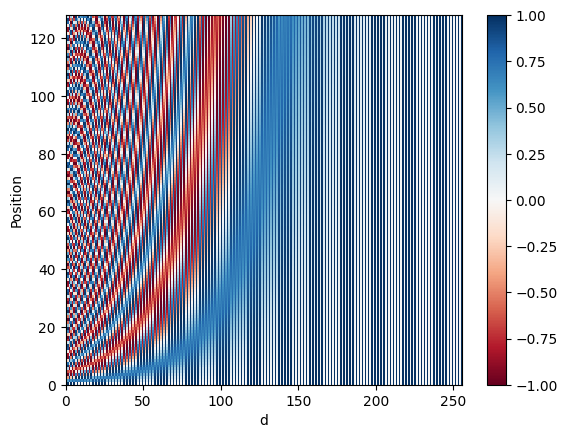

In [71]:
def get_angles(position, k, d_model):
    
    i = k // 2

    angles_rates = 1 / torch.pow(torch.tensor(10000), (2 * i) / d_model)

    return position * angles_rates

def positional_encoding(positions,d):
    angle_rads = get_angles(torch.unsqueeze(torch.arange(positions, dtype=torch.float),-1),torch.unsqueeze(torch.arange(d, dtype=torch.float),0),d)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

    pos_encoding = torch.unsqueeze(angle_rads,0)

    return pos_encoding

pos_encoding = positional_encoding(positions=128,d=256)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()